In [1]:
%pylab inline
import jax
import jax.numpy as jnp
import tensorflow_probability as tfp; tfp = tfp.substrates.jax
tfd = tfp.distributions
tfb = tfp.bijectors

from jaxlie import SO3
from so3dm.distributions.isotropic_gaussian import IsotropicGaussianSO3
from so3dm.plotting import visualize_so3_probabilities, visualize_so3_density

import tensorflow_datasets as tfds
import tensorflow as tf

from flax.metrics import tensorboard
import haiku as hk
import optax

from tqdm import tqdm

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


2023-05-17 12:09:36.685545: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/packages/AI/tensorflow_23.02-2.10.0-py3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.neighbors import radius_neighbors_graph
import jraph
from jraph import GraphConvolution
from jraph._src import utils as jraph_utils
from jraph._src import graph as gn_graph

import networkx as nx
import jax.tree_util as tree
from typing import Any, Callable, Dict, List, Optional, Tuple

In [3]:
import os
os.environ["XLA_FLAGS"]="--xla_gpu_force_compilation_parallelism=1"

In [4]:
%pylab inline
%load_ext autoreload
%autoreload 2
import os
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/tmp/ipykernel_45136/1757885639.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [5]:
jnp.linalg.inv(jnp.eye(3))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [6]:
rng = hk.PRNGSequence(42)


In [7]:
import pickle
from halotools_ia.correlation_functions import  ed_3d, ee_3d,gi_plus_3d, gi_plus_projected, ii_minus_3d, ii_minus_projected, ii_plus_3d, ii_plus_projected, ed_projected, ed_3d_one_two_halo_decomp


In [8]:
tng = pickle.load(  open('/jet/home/yjagvara/SO3Diffusion_Tidal/TNG100-1_99_non-reduced_galaxy_shapes_multi_scale_1024_MLP_only_cent.pkl', "rb" ) )
tng = tng[tng['dm_mass']>0]
tng = tng[log10(tng['dm_mass']*10**10)>9]
tng = tng[log10(tng['mass']*10**10)>9]

tng['mass'] = log10(tng['mass']*10**10)
tng['mass'] = (tng['mass']  -jnp.mean(tng['mass']))/ jnp.std(tng['mass']) 
tng['dm_mass'] = log10(tng['dm_mass']*10**10)
tng['dm_mass'] = (tng['dm_mass']  -jnp.mean(tng['dm_mass']))/ jnp.std(tng['dm_mass']) 

#tng = tng[tng['central_bool']==1.0]
n_scalar = 2 #number of scalar features

In [9]:
tng

gal_id,a,b,c,av_x,av_y,av_z,bv_x,bv_y,bv_z,cv_x,cv_y,cv_z,tid_av_x_0.1_1024,tid_av_y_0.1_1024,tid_av_z_0.1_1024,tid_bv_x_0.1_1024,tid_bv_y_0.1_1024,tid_bv_z_0.1_1024,tid_cv_x_0.1_1024,tid_cv_y_0.1_1024,tid_cv_z_0.1_1024,tid_a_0.1_1024,tid_b_0.1_1024,tid_c_0.1_1024,tid_av_x_0.5_1024,tid_av_y_0.5_1024,tid_av_z_0.5_1024,tid_bv_x_0.5_1024,tid_bv_y_0.5_1024,tid_bv_z_0.5_1024,tid_cv_x_0.5_1024,tid_cv_y_0.5_1024,tid_cv_z_0.5_1024,tid_a_0.5_1024,tid_b_0.5_1024,tid_c_0.5_1024,tid_av_x_1.0_1024,tid_av_y_1.0_1024,tid_av_z_1.0_1024,tid_bv_x_1.0_1024,tid_bv_y_1.0_1024,tid_bv_z_1.0_1024,tid_cv_x_1.0_1024,tid_cv_y_1.0_1024,tid_cv_z_1.0_1024,tid_a_1.0_1024,tid_b_1.0_1024,tid_c_1.0_1024,tid_av_x_2.0_1024,tid_av_y_2.0_1024,tid_av_z_2.0_1024,tid_bv_x_2.0_1024,tid_bv_y_2.0_1024,tid_bv_z_2.0_1024,tid_cv_x_2.0_1024,tid_cv_y_2.0_1024,tid_cv_z_2.0_1024,tid_a_2.0_1024,tid_b_2.0_1024,tid_c_2.0_1024,mass,GroupID,tot_mass,dm_mass,central_bool,group_mass,group_x,group_y,group_z,gal_pos_x,gal_pos_y,gal_pos_z,dm_av_x,dm_av_y,dm_av_z,dm_bv_x,dm_bv_y,dm_bv_z,dm_cv_x,dm_cv_y,dm_cv_z,dm_a,dm_b,dm_c,mlp_av_x,mlp_av_y,mlp_av_z
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0,0.24562844247483243,0.11233008826530698,0.09435347356932028,0.15057356009311798,-0.36432524666271543,0.9190183445639349,-0.6040801058750838,0.7019725376704176,0.37725559246020707,0.7825693762771655,0.611965416507098,0.11438312949234405,0.8275753855705261,0.5501617810833461,-0.11153932645318682,-0.4364806852752775,0.7555949692944677,0.4884269175204382,0.3529923768186143,-0.355525325415916,0.8654467776217399,1054.244087225318,991.9027130436707,668.0261137005616,-0.9183833599090576,0.33972494317589014,0.20287679547321114,0.33534699111399274,0.9403888675675559,-0.05666721544068841,-0.2100343464963115,0.015991896046057438,-0.9775632115381181,59.10935058615099,55.377614125575626,37.975054282341716,0.9371282458305359,0.1784244452709745,-0.29992566920893826,-0.2053100234179685,0.9768323454844315,-0.06038512316371721,0.2822029128212493,0.11816634946180396,0.9520494891811419,13.122050507836377,11.700347539646893,9.282237732126015,-0.8248880505561829,0.33217499988277654,0.4574051124728157,0.5063412900419841,0.7939398479662237,0.3365679958195495,-0.2513526714837356,0.5092340201363678,-0.8231054290148635,2.5250096232145673,2.341083724345102,1.7858375325765965,4.7994876,0.0,27477.935546875,4.9791627,1.0,38878.03515625,849.0914306640625,26326.99609375,18306.93359375,0.8490914106369019,26.326995849609375,18.306934356689453,0.20913785733198287,-0.2376266091458571,0.9485752217175131,-0.0291868731156354,0.9680772186306577,0.24894703293283385,0.9774505015950008,0.07975019369363229,-0.19552601754628252,0.7422561814889702,0.380580342545896,0.2953753041796042,-0.8295962810516357,0.51895672082901,0.5298088788986206
1.0,0.08088470650058953,0.04497213832247513,0.03777383880658522,-0.9840750455762398,-0.006859759853817557,0.17762108086843106,0.07866214907516236,0.8792771126813137,0.46977018361927686,-0.15940066178344028,0.4762611707976621,-0.8647350612837673,-0.25285616517066956,-0.542943046543665,-0.8007974784346137,-0.0015899779481896464,-0.8274600252025045,0.5615223759228073,0.9675025711735737,-0.14325765215776112,-0.20836511193280413,340.0297044488053,304.0921077455601,251.82406385313607,-0.43189844489097595,-0.6954925306839556,-0.5742419895334245,-0.7976906521230697,0

## Let's build the graphs

In [10]:
group_key='GroupID'
pos_key=['gal_pos_x', 'gal_pos_y', 'gal_pos_z']
scalar_key = ['mass', 'dm_mass']
catalog = tng

# It takes a minute but we precompute all the graphs and data
# Identify the individual groups and pre-extract the relevant data

group_ids = catalog[group_key].astype(jnp.int32)
gids, idx = jnp.unique(group_ids, return_index=True) # gids are the unique group ids, in other words All the host halo IDS uniquely  extracted     idx = The indices of the first occurrences of the unique values in the original array. i.e index of the central galaxy
Position = jnp.array(catalog[pos_key].to_pandas())
Scalars = jnp.array(catalog[scalar_key].to_pandas())

In [47]:
graph_radius = 1 #Mpc/h
graphs_list = []
node_features_list = []
positions_list = []
direction_to_COM_list = []


for gid in tqdm(gids):
    
    g = np.where(group_ids == gid)[0]
    Positions_for_group = Position[g]
    Features_for_group = Scalars[g]


    #keep only halos with more than 3 galaxies
    if Features_for_group.shape[0] >10:

        # Compute adjacency matrix for each entry
        graph = radius_neighbors_graph(Positions_for_group, graph_radius, mode='connectivity',
                                   include_self=False)

        Positions_for_group_COM =  (Positions_for_group - Positions_for_group[0])
        directions_to_COM = Positions_for_group_COM/jnp.linalg.norm(Positions_for_group_COM, axis=-1)[..., jnp.newaxis]


        directions_to_COM = directions_to_COM.at[jnp.isnan(directions_to_COM)].set(0.0)

        graphs_list.append(graph)
        node_features_list.append(Features_for_group)

        direction_to_COM_list.append(directions_to_COM)
        positions_list.append(Positions_for_group_COM)

100%|██████████| 10292/10292 [00:21<00:00, 477.92it/s]


In [48]:
len(graphs_list)

127

In [49]:
max_n_node = graphs_list[0].tocoo().shape[0]
max_n_edge = graphs_list[0].tocoo().nnz


In [50]:
senders_list = []
receivers_list = []
n_node_list = []
n_edge_list = []

In [51]:
for single_graph in tqdm(graphs_list):
    single_graph =  single_graph.tocoo()
    
 
    senders = single_graph.row.astype(jnp.int64)
    receivers = single_graph.col.astype(jnp.int64)
    values = single_graph.data.astype(jnp.int64)
    n_node = jnp.asarray([single_graph.shape[0]])
 
    values = np.array([0]) if values.size == 0 else values
    n_edge = np.array([np.sum(values)])
    senders = np.repeat(senders, values)
    receivers = np.repeat(receivers, values)
    
    if len(senders) < max_n_edge:
        senders = jnp.concatenate( [senders, -1*jnp.ones( max_n_edge - len(senders)  )] )
        receivers = jnp.concatenate( [receivers, -1*jnp.ones(max_n_edge - len(receivers)   )] )
        
    
     
    senders_list.append( jnp.asarray(senders).astype(jnp.int32)  )
    receivers_list.append( jnp.asarray(receivers).astype(jnp.int32) )
    
    n_node_list.append( jnp.asarray(n_node).astype(jnp.int32) )
    n_edge_list.append( jnp.asarray(n_edge).astype(jnp.int32) )
    
    
    
    

100%|██████████| 127/127 [00:00<00:00, 553.78it/s]


In [52]:
node_features_list_padded = []
positions_list_padded = []
direction_to_COM_list_padded = []

In [53]:
#here padding the node features with np.inf
for direction_to_COM in tqdm(direction_to_COM_list ):
    if len(direction_to_COM) < max_n_node:
        
        direction_to_COM = jnp.concatenate( [direction_to_COM, 0*jnp.ones( (max_n_node-len(direction_to_COM), jnp.squeeze(direction_to_COM ).shape[-1])  )] )
        
    direction_to_COM_list_padded.append( jnp.asarray(direction_to_COM).astype(jnp.float32)  )
        

100%|██████████| 127/127 [00:00<00:00, 1311.16it/s]


In [54]:
#here padding the node features with np.inf
for node_features in tqdm(node_features_list ):
    if len(node_features) < max_n_node:
        
        node_features = jnp.concatenate( [node_features, 0*jnp.ones( (max_n_node-len(node_features), jnp.squeeze(node_features ).shape[-1])  )] )
        
    node_features_list_padded.append( jnp.asarray(node_features).astype(jnp.float32)  )
        

100%|██████████| 127/127 [00:00<00:00, 1312.99it/s]


In [55]:
#here padding the node features with np.inf
for positions in tqdm(positions_list ):
    if len(positions) < max_n_node:
        
        positions = jnp.concatenate( [positions, 0*jnp.ones( (max_n_node-len(positions), jnp.squeeze(positions ).shape[-1])  )] )
        
    positions_list_padded.append( jnp.asarray(positions).astype(jnp.float32)  )
        

100%|██████████| 127/127 [00:00<00:00, 1360.71it/s]


In [56]:
senders_list = jnp.array(senders_list)
receivers_list = jnp.array(receivers_list)

n_node_list = jnp.array(n_node_list)
n_edge_list = jnp.array(n_edge_list)

node_features_list_padded = jnp.array(node_features_list_padded)
positions_list_padded = jnp.array(positions_list_padded)
direction_to_COM_list_padded = jnp.array(direction_to_COM_list_padded)

In [57]:
concat_feats = jnp.concatenate([node_features_list_padded,   direction_to_COM_list_padded, positions_list_padded], axis=-1)

In [58]:
GP =  gn_graph.GraphsTuple(
      nodes=concat_feats,  
      edges=-1*jnp.ones_like(n_node_list),
      receivers= receivers_list   ,
      senders= senders_list ,
      globals=  -1*jnp.ones_like(n_node_list),
      n_node=n_node_list,
      n_edge=n_edge_list)

In [59]:
batch_size = 64

dset = tf.data.Dataset.from_tensor_slices(GP)

dset = dset.repeat()
dset = dset.shuffle(buffer_size=10000)
dset = dset.batch(batch_size)
dset = dset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
dset = dset.as_numpy_iterator()
_ = next(dset)

In [60]:
g = next(dset)

In [61]:


dset2 = tf.data.Dataset.from_tensor_slices(GP)

dset2 = dset2.repeat()
dset2 = dset2.shuffle(buffer_size=10000)
dset2 = dset2.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
dset2 = dset2.as_numpy_iterator()
g_init = next(dset2)

In [62]:
def f_e(feats: jnp.ndarray, in_dim) -> jnp.ndarray:
  """Node update function for graph net."""
  net = hk.nets.MLP([in_dim , in_dim ], activation=jax.nn.silu)(feats)
  return net

def f_inf(m_ij: jnp.ndarray, in_dim) -> jnp.ndarray:
  """Node update function for graph net."""
  net = hk.nets.MLP( [1,], activation=jax.nn.sigmoid)(m_ij)
  return net

def f_h(feats: jnp.ndarray, in_dim) -> jnp.ndarray:
  """Node update function for graph net."""
  net = hk.nets.MLP([in_dim,  ], activation=jax.nn.silu)(feats)
  net = hk.Linear(in_dim)(net)
  return net


def f_x(feats: jnp.ndarray, in_dim) -> jnp.ndarray:
  """Node update function for graph net."""
  net = hk.nets.MLP([in_dim, in_dim  ], activation=jax.nn.silu)(feats)
  net = hk.Linear(1)(net) 
  return net



In [63]:
# GAT modified
def GNN(add_self_edges: bool = False ) -> Callable:
  def _ApplyGNN(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
 
    nodes, edges, receivers, senders, _, _, _ = graph
    
    
    # Equivalent to the sum of n_node, but statically known.
    try:
      sum_n_node = nodes.shape[0]
    except IndexError:
      raise IndexError('GAT requires node features')

    
    
    # position of the nodes are the last 3 entries in the features matrix
    distances = jnp.linalg.norm( nodes[:,-3:][senders] - nodes[:,-3:][receivers], axis=-1)
    node_feat = nodes[:,:n_scalar]
    
    input_dim = nodes[:,:n_scalar].shape[-1]
    
    
    concat_feats = jnp.concatenate([ node_feat[senders], node_feat[receivers], distances.reshape((-1,1))**2 ], axis=-1)
    m_ij = f_e(concat_feats, input_dim)
    
    
    # predict edges
    e_ij = f_inf(m_ij, input_dim)
    
    m_i = jraph_utils.segment_sum( e_ij*m_ij, receivers, num_segments=sum_n_node)

    concat_for_hl1_i =  jnp.concatenate([node_feat,  m_i], axis=-1)
    
    
    new_node_feat = node_feat + f_h(concat_for_hl1_i, input_dim) #h^(l+1)_i    f_h is the node update func

     
    position_mlp = f_x(concat_feats, input_dim)
    prefac_xi_xj = (nodes[:,-3:][senders] - nodes[:,-3:][receivers])/ (distances.reshape((-1,1))+1)
    
    sum_xi_xj =  jraph_utils.segment_sum( prefac_xi_xj*position_mlp, receivers, num_segments=sum_n_node)
    #sum_xi_xj = jnp.einsum('ij,ij ->i', prefac_xi_xj, position_mlp ) #f_x
    
    x_Lplus1_i = nodes[:,-3:] + sum_xi_xj
      
    
    

    x_Lplus1_i = x_Lplus1_i/jnp.linalg.norm(x_Lplus1_i, axis=-1 )[..., jnp.newaxis]
    mask = jnp.isnan(x_Lplus1_i)  # boolean mask selecting non-nan values
    x_Lplus1_i = jnp.where(~mask, x_Lplus1_i, 0)
    
    #x_Lplus1_i = jnp.nan_to_num(x_Lplus1_i, copy=False,nan=0.0, posinf=0.0, neginf=0.0)#    x_Lplus1_i.at[jnp.isnan(x_Lplus1_i)].set(0.0)
    
    
    nodes = jnp.concatenate([new_node_feat, x_Lplus1_i],axis=-1)
    #print(nodes.shape)
    return graph._replace(nodes=nodes)

  # pylint: enable=g-long-lambda
  return _ApplyGNN

In [64]:
def dim_expand_MLP(feats: jnp.ndarray, out_dim) -> jnp.ndarray:
  """Node update function for graph net."""
  net = hk.nets.MLP( [out_dim] )(feats)
  return net


def dim_expand(graph: jraph.GraphsTuple, out_dim) -> jraph.GraphsTuple:

    nodes, edges, receivers, senders, _, _, _ = graph

    node_feat = nodes[:,:n_scalar]
 
    new_node = dim_expand_MLP(node_feat, out_dim)
    
    nodes = jnp.concatenate([new_node, nodes[:,n_scalar:]],axis=-1)

     
    return graph._replace(nodes=nodes)
 

In [65]:
 

def gcn_definition(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  """Defines a GCN for the karate club task.
  Args:
    graph: GraphsTuple the network processes.

  Returns:
    output graph with updated node values.
  """
  graph = dim_expand(graph,   64)
    
  gn = GNN( 
      add_self_edges=False )
  graph = gn(graph)
  
  

  gn = GNN(add_self_edges=False) # output dim is 2 because we have 2 scalars.
  graph = gn(graph)
    
  graph = dim_expand(graph,   0)
  graph = SO3_MLP(graph,   0)#only do node operations, no messages


  return graph

In [66]:
network = hk.without_apply_rng(hk.transform(gcn_definition ))


#params = jax.vmap(lambda x: network.init( next(rng) , x))  (g)

params =  network.init( next(rng) , g_init )

#out_graph = jax.vmap(lambda x,y: network.apply(x,y))   (params, g)
 

In [67]:
@jax.jit
def prediction_loss(params: hk.Params, graph_batch: jraph.GraphsTuple ) -> jnp.ndarray:
    
    predicted_graph = jax.vmap ( lambda x: network.apply(params, x)) (graph_batch)

    #print(predicted_graph.nodes.shape)
    loss =  jnp.linalg.norm(predicted_graph.nodes   -  graph_batch.nodes[:,:,n_scalar:-3], axis=-1) **2
    
    return jnp.mean(loss)



In [68]:
opt_init, opt_update = optax.adam(1e-3)
opt_state = opt_init(params)

In [69]:
@jax.jit
def update(params: hk.Params, opt_state, graph_batch: jraph.GraphsTuple) -> Tuple[hk.Params, Any]:
    
    loss, grads = jax.value_and_grad(prediction_loss)(params, graph_batch)

    updates, opt_state = opt_update(grads, opt_state)
    
    return optax.apply_updates(params, updates), opt_state, loss


In [70]:
losses = []
params_list = []

In [76]:
for step in tqdm(range(10_000)):
    params, opt_state, loss = update(params, opt_state, next(dset))

    #print(loss)
    if jnp.isnan(loss):
        break
    
    if step%10==0 or step==0:
        pickle.dump( params_list, open( "/ocean/projects/phy210062p/yjagvara/EGNN_normed_weights.p", "wb" ) )
        pickle.dump( losses, open( "/ocean/projects/phy210062p/yjagvara/EGNN_normed_losses.p", "wb" ) )
        losses.append(loss)
        params_list.append(params)

 10%|▉         | 997/10000 [08:52<1:20:08,  1.87it/s]


KeyboardInterrupt: 

losses = pickle.load(open( "/ocean/projects/phy210062p/yjagvara/EGNN_losses.p", "rb" ))
params_list = pickle.load(open( "/ocean/projects/phy210062p/yjagvara/EGNN_weights.p", "rb" ))

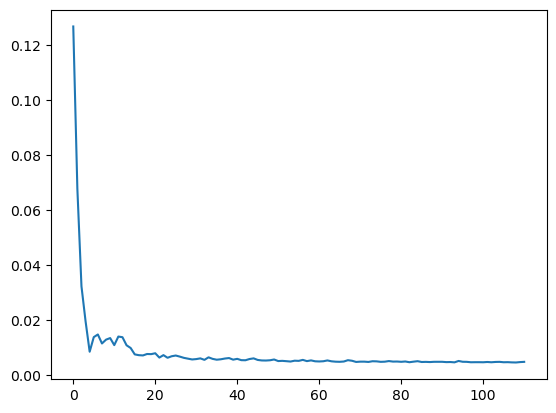

In [77]:
plot(losses)

In [78]:
predicted_graph = jax.vmap ( lambda x: network.apply(params_list[-1], x)) (GP)

In [79]:
predicted_graph.nodes

Array([[[ 0.33613867, -0.44031984,  0.8325438 ],
        [-0.22882392, -0.7518408 , -0.6183648 ],
        [-0.06892178,  0.41740564, -0.9061028 ],
        ...,
        [-0.04359097, -0.5086614 ,  0.8598625 ],
        [-0.52891666,  0.17516007, -0.8304012 ],
        [-0.4567476 ,  0.84183264, -0.28757527]],

       [[-0.1001392 , -0.98115444, -0.16525164],
        [ 0.34708512,  0.90602285, -0.24218705],
        [-0.52720004,  0.8026343 , -0.2789953 ],
        ...,
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       [[-0.99178797,  0.10789541, -0.06866731],
        [ 0.90396374, -0.37521073,  0.20510112],
        [-0.7398457 ,  0.52689326,  0.4183441 ],
        ...,
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       ...,

       [[-0.6851682 , -0.6816816 , -0.2566219 ],
        [ 0

In [80]:
GP.nodes[:,:,n_scalar:n_scalar+3]

Array([[[ 0.        ,  0.        ,  0.        ],
        [-0.31963342, -0.7289815 , -0.6053267 ],
        [ 0.00451522,  0.44777012, -0.8941373 ],
        ...,
        [-0.06840579, -0.47151485,  0.87920105],
        [-0.5615869 ,  0.16895355, -0.80998445],
        [-0.4402635 ,  0.8673947 , -0.23193628]],

       [[ 0.        ,  0.        ,  0.        ],
        [ 0.3457772 ,  0.88918585, -0.29964423],
        [-0.3076508 ,  0.9221939 , -0.23432787],
        ...,
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ],
        [ 0.89865893, -0.3946824 ,  0.19141051],
        [-0.76007426,  0.5070386 ,  0.40644696],
        ...,
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       ...,

       [[ 0.        ,  0.        ,  0.        ],
        [ 0

In [100]:
t = jnp.einsum('...k,...k->...' ,  predicted_graph.nodes, GP.nodes[:,:,n_scalar:n_scalar+3])

In [102]:
t_new = np.ma.masked_equal(t,0)
print(t_new.shape)


(127, 227)


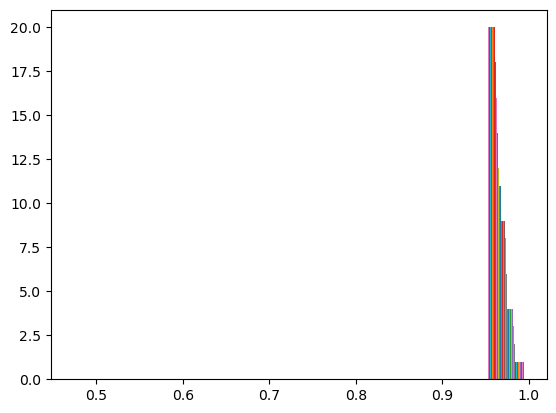

In [112]:
x=hist(t_new[:20],bins=10,density=False)

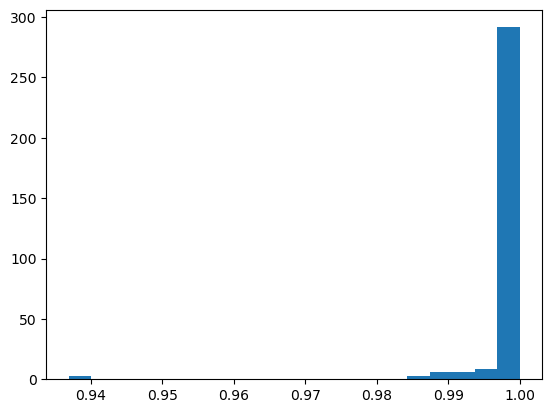

In [109]:
a=hist(t_new[5],bins=20,density=True)

In [ ]:

@jraph.concatenated_args
def node_update_fn(feats: jnp.ndarray) -> jnp.ndarray:
  """Node update function for graph net."""
  net = hk.Sequential(
      [hk.Linear(128), jax.nn.relu,
       hk.Linear(128)])
  return net(feats)


def net_fn(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  # Add a global paramater for graph classification.
  graph = graph._replace(globals=jnp.zeros([graph.n_node.shape[0], 1]))
  embedder = jraph.GraphMapFeatures(
      hk.Linear(128), hk.Linear(128), hk.Linear(128))
  net = jraph.GraphNetwork(
      update_node_fn=node_update_fn,
      update_edge_fn=edge_update_fn,
      update_global_fn=update_global_fn)
  return net(embedder(graph)) 

In [ ]:
def compute_loss(params: hk.Params, graph: jraph.GraphsTuple, label: jnp.ndarray,
                 net: jraph.GraphsTuple) -> Tuple[jnp.ndarray, jnp.ndarray]:
  """Computes loss and accuracy."""
  pred_graph = net.apply(params, graph)
  preds = jax.nn.log_softmax(pred_graph.globals)
  targets = jax.nn.one_hot(label, 2)

  # Since we have an extra 'dummy' graph in our batch due to padding, we want
  # to mask out any loss associated with the dummy graph.
  # Since we padded with `pad_with_graphs` we can recover the mask by using
  # get_graph_padding_mask.
  mask = jraph.get_graph_padding_mask(pred_graph)

  # Cross entropy loss.
  loss = -jnp.mean(preds * targets * mask[:, None])

  # Accuracy taking into account the mask.
  accuracy = jnp.sum(
      (jnp.argmax(pred_graph.globals, axis=1) == label) * mask) / jnp.sum(mask)
  return loss, accuracy

In [ ]:
# Adapted from https://github.com/deepmind/jraph/blob/master/jraph/ogb_examples/train.py
def train(dataset: List[Dict[str, Any]], num_train_steps: int) -> hk.Params:
  """Training loop."""

  # Transform impure `net_fn` to pure functions with hk.transform.
  net = hk.without_apply_rng(hk.transform(net_fn))
  # Get a candidate graph and label to initialize the network.
  graph = dataset[0]['input_graph']

  # Initialize the network.
  params = net.init(jax.random.PRNGKey(42), graph)
  # Initialize the optimizer.
  opt_init, opt_update = optax.adam(1e-4)
  opt_state = opt_init(params)

  compute_loss_fn = functools.partial(compute_loss, net=net)
  # We jit the computation of our loss, since this is the main computation.
  # Using jax.jit means that we will use a single accelerator. If you want
  # to use more than 1 accelerator, use jax.pmap. More information can be
  # found in the jax documentation.
  compute_loss_fn = jax.jit(jax.value_and_grad(
      compute_loss_fn, has_aux=True))

  for idx in range(num_train_steps):
    graph = dataset[idx % len(dataset)]['input_graph']
    label = dataset[idx % len(dataset)]['target']
    # Jax will re-jit your graphnet every time a new graph shape is encountered.
    # In the limit, this means a new compilation every training step, which
    # will result in *extremely* slow training. To prevent this, pad each
    # batch of graphs to the nearest power of two. Since jax maintains a cache
    # of compiled programs, the compilation cost is amortized.
    graph = pad_graph_to_nearest_power_of_two(graph)

    # Since padding is implemented with pad_with_graphs, an extra graph has
    # been added to the batch, which means there should be an extra label.
    label = jnp.concatenate([label, jnp.array([0])])

    (loss, acc), grad = compute_loss_fn(params, graph, label)
    updates, opt_state = opt_update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    if idx % 50 == 0:
      print(f'step: {idx}, loss: {loss}, acc: {acc}')
  print('Training finished')
  return params

In [ ]:
params = train(train_mutag_ds, num_train_steps=500)

In [ ]:
class MLP(hk.Module):
  def __init__(self, features: jnp.ndarray):
    super().__init__()
    self.features = features

  def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
    layers = []
    for feat in self.features[:-1]:
      layers.append(hk.Linear(feat))
      layers.append(jax.nn.relu)
    layers.append(hk.Linear(self.features[-1]))

    mlp = hk.Sequential(layers)
    return mlp(x)

# Use MLP block to define the update node function
update_node_fn = lambda x: MLP(features=[8, 4])(x)

In [ ]:
# Adapted from https://github.com/deepmind/jraph/blob/master/jraph/_src/models.py#L506
def GraphConvolution(update_node_fn: Callable,
                     aggregate_nodes_fn: Callable = jax.ops.segment_sum,
                     add_self_edges: bool = False,
                     symmetric_normalization: bool = False) -> Callable:
  """Returns a method that applies a Graph Convolution layer.

  Graph Convolutional layer as in https://arxiv.org/abs/1609.02907,
  NOTE: This implementation does not add an activation after aggregation.
  If you are stacking layers, you may want to add an activation between
  each layer.
  Args:
    update_node_fn: function used to update the nodes. In the paper a single
      layer MLP is used.
    aggregate_nodes_fn: function used to aggregates the sender nodes.
    add_self_edges: whether to add self edges to nodes in the graph as in the
      paper definition of GCN. Defaults to False.
    symmetric_normalization: whether to use symmetric normalization. Defaults to
      True.

  Returns:
    A method that applies a Graph Convolution layer.
  """

  def _ApplyGCN(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Applies a Graph Convolution layer."""
    nodes, _, receivers, senders, _, _, _ = graph

    # First pass nodes through the node updater.
    nodes = update_node_fn(nodes)
    # Equivalent to jnp.sum(n_node), but jittable
    total_num_nodes = tree.tree_leaves(nodes)[0].shape[0]
    if add_self_edges:
      # We add self edges to the senders and receivers so that each node
      # includes itself in aggregation.
      # In principle, a `GraphsTuple` should partition by n_edge, but in
      # this case it is not required since a GCN is agnostic to whether
      # the `GraphsTuple` is a batch of graphs or a single large graph.
      conv_receivers, conv_senders = add_self_edges_fn(receivers, senders,
                                                       total_num_nodes)
    else:
      conv_senders = senders
      conv_receivers = receivers

    # pylint: disable=g-long-lambda
    if symmetric_normalization:
      # Calculate the normalization values.
      count_edges = lambda x: jax.ops.segment_sum(
          jnp.ones_like(conv_senders), x, total_num_nodes)
      sender_degree = count_edges(conv_senders)
      receiver_degree = count_edges(conv_receivers)

      # Pre normalize by sqrt sender degree.
      # Avoid dividing by 0 by taking maximum of (degree, 1).
      nodes = tree.tree_map(
          lambda x: x * jax.lax.rsqrt(jnp.maximum(sender_degree, 1.0))[:, None],
          nodes,
      )
      # Aggregate the pre-normalized nodes.
      nodes = tree.tree_map(
          lambda x: aggregate_nodes_fn(x[conv_senders], conv_receivers,
                                       total_num_nodes), nodes)
      # Post normalize by sqrt receiver degree.
      # Avoid dividing by 0 by taking maximum of (degree, 1).
      nodes = tree.tree_map(
          lambda x:
          (x * jax.lax.rsqrt(jnp.maximum(receiver_degree, 1.0))[:, None]),
          nodes,
      )
    else:
      nodes = tree.tree_map(
          lambda x: aggregate_nodes_fn(x[conv_senders], conv_receivers,
                                       total_num_nodes), nodes)
    # pylint: enable=g-long-lambda
    return graph._replace(nodes=nodes)

  return _ApplyGCN

In [ ]:
def gcn(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  """Defines a graph neural network with 3 GCN layers.
  Args:
    graph: GraphsTuple the network processes.

  Returns:
    output graph with updated node values.
  """
  gn = GraphConvolution(
      update_node_fn=lambda n: jax.nn.relu(hk.Linear(8)(n)),
      add_self_edges=False)
  graph = gn(graph)

  gn = GraphConvolution(
      update_node_fn=lambda n: jax.nn.relu(hk.Linear(4)(n)),
      add_self_edges=False)
  graph = gn(graph)

  gn = GraphConvolution(
      update_node_fn=hk.Linear(2))
  graph = gn(graph)
  return graph

In [ ]:
# Adapted from https://github.com/deepmind/jraph/blob/master/jraph/_src/models.py#L506
def GraphConvolution(update_node_fn: Callable,
                     aggregate_nodes_fn: Callable = jax.ops.segment_sum,
                     add_self_edges: bool = False,
                     symmetric_normalization: bool = False) -> Callable:
  """Returns a method that applies a Graph Convolution layer.

  Graph Convolutional layer as in https://arxiv.org/abs/1609.02907,
  NOTE: This implementation does not add an activation after aggregation.
  If you are stacking layers, you may want to add an activation between
  each layer.
  Args:
    update_node_fn: function used to update the nodes. In the paper a single
      layer MLP is used.
    aggregate_nodes_fn: function used to aggregates the sender nodes.
    add_self_edges: whether to add self edges to nodes in the graph as in the
      paper definition of GCN. Defaults to False.
    symmetric_normalization: whether to use symmetric normalization. Defaults to
      True.

  Returns:
    A method that applies a Graph Convolution layer.
  """

  def _ApplyGCN(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Applies a Graph Convolution layer."""
    nodes, _, receivers, senders, _, _, _ = graph

    # First pass nodes through the node updater.
    nodes = update_node_fn(nodes)
    # Equivalent to jnp.sum(n_node), but jittable
    total_num_nodes = tree.tree_leaves(nodes)[0].shape[0]
    if add_self_edges:
      # We add self edges to the senders and receivers so that each node
      # includes itself in aggregation.
      # In principle, a `GraphsTuple` should partition by n_edge, but in
      # this case it is not required since a GCN is agnostic to whether
      # the `GraphsTuple` is a batch of graphs or a single large graph.
      conv_receivers, conv_senders = add_self_edges_fn(receivers, senders,
                                                       total_num_nodes)
    else:
      conv_senders = senders
      conv_receivers = receivers

    # pylint: disable=g-long-lambda
    if symmetric_normalization:
      # Calculate the normalization values.
      count_edges = lambda x: jax.ops.segment_sum(
          jnp.ones_like(conv_senders), x, total_num_nodes)
      sender_degree = count_edges(conv_senders)
      receiver_degree = count_edges(conv_receivers)

      # Pre normalize by sqrt sender degree.
      # Avoid dividing by 0 by taking maximum of (degree, 1).
      nodes = tree.tree_map(
          lambda x: x * jax.lax.rsqrt(jnp.maximum(sender_degree, 1.0))[:, None],
          nodes,
      )
      # Aggregate the pre-normalized nodes.
      nodes = tree.tree_map(
          lambda x: aggregate_nodes_fn(x[conv_senders], conv_receivers,
                                       total_num_nodes), nodes)
      # Post normalize by sqrt receiver degree.
      # Avoid dividing by 0 by taking maximum of (degree, 1).
      nodes = tree.tree_map(
          lambda x:
          (x * jax.lax.rsqrt(jnp.maximum(receiver_degree, 1.0))[:, None]),
          nodes,
      )
    else:
      nodes = tree.tree_map(
          lambda x: aggregate_nodes_fn(x[conv_senders], conv_receivers,
                                       total_num_nodes), nodes)
    # pylint: enable=g-long-lambda
    return graph._replace(nodes=nodes)

  return _ApplyGCN

In [ ]:
# GAT modified
def GNN(add_self_edges: bool = False ) -> Callable:
 
 

  def _ApplyGNN(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
 
    nodes, edges, receivers, senders, _, _, _ = graph
    
    
    #Equivalent to the sum of n_node, but statically known.
    try:
      sum_n_node = nodes.shape[0]
    except IndexError:
      raise IndexError('GAT requires node features')

    
    
    
    
    # position of the nodes are the last 3 entries in the features matrix
    
    distances = jnp.linalg.norm( nodes[:,:3][senders] - nodes[:,:3][receivers], axis=-1)
    node_feat = nodes[:,3:]
    
    input_dim = nodes[:,3:].shape[-1]
    
    
    concat_feats = jnp.concatenate([ node_feat[senders], node_feat[receivers], distances.reshape((-1,1))**2 ], axis=-1)
    m_ij = f_e(concat_feats, input_dim)
    
    
    # predict edges
    e_ij = f_inf(m_ij, input_dim)
    
    m_i = jraph_utils.segment_sum( e_ij*m_ij, receivers, num_segments=sum_n_node)

    concat_for_hl1_i =  jnp.concatenate([node_feat,  m_i], axis=-1)
    
    
    new_node_feat = node_feat + f_h(concat_for_hl1_i, input_dim) #h^(l+1)_i    f_h is the node update func

     
    position_mlp = f_x(concat_feats, input_dim)
    prefac_xi_xj = (nodes[:,:3][senders] - nodes[:,:3][receivers])/ (distances.reshape((-1,1))+1)
    
    sum_xi_xj =  jraph_utils.segment_sum( prefac_xi_xj*position_mlp, receivers, num_segments=sum_n_node)
    #sum_xi_xj = jnp.einsum('ij,ij ->i', prefac_xi_xj, position_mlp ) #f_x
    
    x_Lplus1_i = nodes[:,:3] + sum_xi_xj
    
    nodes = jnp.concatenate([x_Lplus1_i, new_node_feat],axis=-1)
    #print(nodes.shape)
    return graph._replace(nodes=nodes)

  # pylint: enable=g-long-lambda
  return _ApplyGNN

In [ ]:
def dim_expand_MLP(feats: jnp.ndarray, out_dim) -> jnp.ndarray:
  """Node update function for graph net."""
  net = hk.Linear( out_dim )(feats)
  return net


def dim_expand(graph: jraph.GraphsTuple, out_dim) -> jraph.GraphsTuple:

    nodes, edges, receivers, senders, _, _, _ = graph

    node_feat = nodes[:,3:]
    in_dim = nodes[:,3:].shape[-1]
    new_node = dim_expand_MLP(node_feat, out_dim)
    
    nodes = jnp.concatenate([nodes[:,:3], new_node],axis=-1)

     
    return graph._replace(nodes=nodes)
 